In [23]:

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import product
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,fbeta_score
#from sklearn.svm import OneClassSVM
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', None)

## DATA PREP

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/sebastiansossah/TFM/main/data/df.zip', index_col=0)

C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_14536\2866093463.py:1: DtypeWarning: Columns (3,4,5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/sebastiansossah/TFM/main/data/df.zip', index_col=0)


In [25]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.set_index('Timestamp')
df = df.sort_index()

In [26]:
df.shape

(116166, 99)

In [27]:
def create_sliding_windows(df, window_size, stride):
    """
    Crea ventanas deslizantes separando normal vs anomalía
    + metadata para mapeo ventana → evento
    
    Returns:
        windows_train: lista de ventanas normales
        windows_test: lista de ventanas con anomalías
        metadata_train: dict con info de cada ventana train
        metadata_test: dict con info de cada ventana test
    """
    if 'Block_ID' not in df.columns or 'Anomaly_Event' not in df.columns:
        print("Necesitas Block_ID y Anomaly_Event")
        return None, None, None, None
    
    windows_train = []
    windows_test = []
    metadata_train = []
    metadata_test = []
    
    train_idx = 0
    test_idx = 0
    
    # Procesar cada bloque
    for block_id in sorted(df['Block_ID'].unique()):
        block_data = df[df['Block_ID'] == block_id].copy()
        
        # Crear ventanas deslizantes
        for i in range(0, len(block_data) - window_size + 1, stride):
            window = block_data.iloc[i:i+window_size]
            
            # Metadata común
            meta = {
                'block_id': block_id,
                'start_time': window.index[0],
                'end_time': window.index[-1],
                'start_idx_in_block': i,
                'anomaly_event': int(window['Anomaly_Event'].max()),
                'has_anomaly': bool(window['Anomaly'].any()),
                'n_anomaly_records': int(window['Anomaly'].sum())
            }
            
            # Separar train/test
            if window['Anomaly_Event'].max() > 0:
                meta['window_idx'] = test_idx
                meta['split'] = 'test'
                windows_test.append(window)
                metadata_test.append(meta)
                test_idx += 1
            else:
                meta['window_idx'] = train_idx
                meta['split'] = 'train'
                windows_train.append(window)
                metadata_train.append(meta)
                train_idx += 1
    
    print(f"Ventanas train (normales): {len(windows_train)}")
    print(f"Ventanas test (con anomalías): {len(windows_test)}")
    
    if len(windows_train) > 0:
        total_train_records = sum(len(w) for w in windows_train)
        print(f"Registros totales en train: {total_train_records}")
    
    if len(windows_test) > 0:
        total_test_records = sum(len(w) for w in windows_test)
        anomaly_records = sum((w['Anomaly'] == 1).sum() for w in windows_test)
        print(f"Registros totales en test: {total_test_records}")
        print(f"Registros con anomalía en test: {anomaly_records}")
        
        # Info de eventos
        unique_events = set(m['anomaly_event'] for m in metadata_test)
        print(f"Eventos únicos en test: {len(unique_events)}")
    
    return windows_train, windows_test, metadata_train, metadata_test

In [28]:
def prepare_data_model_with_pca(
        windows_train, 
        windows_test, 
        pca_components=None
    ):
    """
    Prepara datos con normalización diferenciada para sensores/actuadores
    y añade PCA opcional sobre las ventanas flatten.
    """
    # -------------------------
    # 1. Definir features
    # -------------------------
    continuous_features = [
        'FIT101', 'LIT101',
        'AIT201', 'AIT202', 'AIT203', 'FIT201',
        'AIT301', 'AIT302', 'AIT303', 'DPIT301', 'FIT301', 'LIT301',
        'AIT401', 'AIT402', 'FIT401', 'LIT401',
        'AIT501', 'AIT502', 'AIT503', 'AIT504',
        'FIT501', 'FIT502', 'FIT503', 'FIT504',
        'PIT501', 'PIT502', 'PIT503',
        'FIT601', 'FIT602', 'LIT601', 'LIT602'
    ]
    
    binary_features = [
        'MV101', 'P101', 'P102',
        'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206',
        'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302',
        'P401', 'P402', 'P403', 'P404', 'UV401',
        'MV501', 'MV502', 'MV503', 'MV504', 'P501', 'P502',
        'P601', 'P602', 'P603'
    ]
    
    all_features = continuous_features + binary_features
    
    # -------------------------
    # 2. Convertir ventanas a arrays
    # -------------------------
    X_train = np.array([w[all_features].values for w in windows_train])
    X_test = np.array([w[all_features].values for w in windows_test])
    
    n_cont = len(continuous_features)
    
    # -------------------------
    # 3. Separar continuas/binarias
    # -------------------------
    X_train_cont = X_train[:, :, :n_cont]
    X_train_bin  = X_train[:, :, n_cont:]
    X_test_cont  = X_test[:, :, :n_cont]
    X_test_bin   = X_test[:, :, n_cont:]
    
    # -------------------------
    # 4. Escalar continuas
    # -------------------------
    scaler = StandardScaler()
    
    n_train, window_size, _ = X_train_cont.shape
    
    # reshape temporario para escalado
    X_train_cont_rs = X_train_cont.reshape(-1, n_cont)
    X_test_cont_rs  = X_test_cont.reshape(-1, n_cont)
    
    X_train_cont_scaled = scaler.fit_transform(X_train_cont_rs)
    X_test_cont_scaled  = scaler.transform(X_test_cont_rs)
    
    # reshape de vuelta a ventanas
    X_train_cont = X_train_cont_scaled.reshape(n_train, window_size, n_cont)
    X_test_cont  = X_test_cont_scaled.reshape(X_test_cont.shape[0], window_size, n_cont)
    
    # -------------------------
    # 5. Recombinar continuas + binarias
    # -------------------------
    X_train_final = np.concatenate([X_train_cont, X_train_bin], axis=2)
    X_test_final  = np.concatenate([X_test_cont, X_test_bin], axis=2)
    
    # -------------------------
    # 6. PCA (opcional)
    # -------------------------
    if pca_components is not None:
        print("\nAplicando PCA...")

        # reshape a (n_windows, window_size * n_features)
        n_features_total = X_train_final.shape[2]
        
        X_train_flat = X_train_final.reshape(X_train_final.shape[0], window_size * n_features_total)
        X_test_flat  = X_test_final.reshape(X_test_final.shape[0], window_size * n_features_total)

        # PCA
        pca = PCA(n_components=pca_components)
        X_train_pca = pca.fit_transform(X_train_flat)
        X_test_pca  = pca.transform(X_test_flat)

        print("Dimensión original:", window_size * n_features_total)
        print("Dimensión PCA:", X_train_pca.shape[1])
        print("Varianza explicada acumulada:", pca.explained_variance_ratio_.sum())

        return X_train_pca, X_test_pca, scaler, pca, all_features
    
    # -------------------------
    # 7. Si no hay PCA → flatten normal
    # -------------------------
    X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
    X_test_flat  = X_test_final.reshape(X_test_final.shape[0],  -1)

    return X_train_flat, X_test_flat, scaler, all_features


In [30]:
EXPERIMENT_CONFIG = {
    'strides': [5,15,30],
    'pca':[10,20,61],
    'window_size': [60],
    "n_neighbors": [5,10,15,20,25,30],
    "method": ["largest", "mean", "median"],  
    "contamination": [0.005, 0.01, 0.02]}

In [31]:
count= 0
for i in product(EXPERIMENT_CONFIG['strides'], 
                 EXPERIMENT_CONFIG['pca'],
            EXPERIMENT_CONFIG['n_neighbors'], 
            EXPERIMENT_CONFIG['method'], 
            EXPERIMENT_CONFIG['contamination']
            ):
    count+=1
print(count)

486


In [32]:
from math import prod

count = prod(len(EXPERIMENT_CONFIG[key]) for key in ['strides', 'n_neighbors', 'method', 'contamination'])
print(count)

162


In [33]:

log_result_params = []


for stride, pca_param,window_size in product(EXPERIMENT_CONFIG['strides'], EXPERIMENT_CONFIG['pca'],EXPERIMENT_CONFIG['window_size']):
    windows_train, windows_test, metadata_train, metadata_test = create_sliding_windows(
                    df, 
                    window_size=window_size, 
                    stride=stride)

    X_train, X_test, scaler, pca, all_features = prepare_data_model_with_pca(
        windows_train, 
        windows_test, 
        pca_components=pca_param)

    for  n_neighbors, method, contamination in product(
                EXPERIMENT_CONFIG['n_neighbors'], 
                EXPERIMENT_CONFIG['method'], 
                EXPERIMENT_CONFIG['contamination']
                ):

        knn = KNN(
        n_neighbors=n_neighbors,
        method=method,
        contamination=contamination,
        n_jobs=-1)

        precision, recall, f1, mae, medae = get_results(knn, X_train, X_test, score=0) 

        log_result_params.append(
            {'strides':stride,
                'window':60,
                'pca':pca_param,
                'n_neighbors':n_neighbors,
                'method':method,
                'contamination':contamination,
                'precision':precision, 'recall':recall,'mae':mae, 'medae':medae ,'f1': f1})

        

Ventanas train (normales): 14633
Ventanas test (con anomalías): 8486
Registros totales en train: 877980
Registros totales en test: 509160
Registros con anomalía en test: 259420
Eventos únicos en test: 515

Aplicando PCA...
Dimensión original: 3660
Dimensión PCA: 10
Varianza explicada acumulada: 0.8618053986044781
Ventanas train (normales): 14633
Ventanas test (con anomalías): 8486
Registros totales en train: 877980
Registros totales en test: 509160
Registros con anomalía en test: 259420
Eventos únicos en test: 515

Aplicando PCA...
Dimensión original: 3660
Dimensión PCA: 20
Varianza explicada acumulada: 0.9339858939590736


KeyboardInterrupt: 

In [ ]:
len(log_result_params)

486

In [ ]:
df_resultados = pd.DataFrame(log_result_params)

In [ ]:
df_resultados.sort_values(by='f1', ascending=False)

,strides,window,pca,n_neighbors,method,contamination,precision,recall,mae,medae,f1
243,15,60,20,20,largest,0.005,0.368093,1.0,14.848002,14.724025,0.538111
241,15,60,20,15,median,0.010,0.368093,1.0,16.390386,15.513433,0.538111
219,15,60,20,5,mean,0.005,0.368093,1.0,15.862819,14.065151,0.538111
218,15,60,20,5,largest,0.020,0.368093,1.0,16.325770,15.179215,0.538111
217,15,60,20,5,largest,0.010,0.368093,1.0,16.325770,15.179215,0.538111
...,...,...,...,...,...,...,...,...,...,...,...
107,5,60,20,30,median,0.020,0.367057,1.0,16.698059,15.523802,0.537004
106,5,60,20,30,median,0.010,0.367057,1.0,16.698059,15.523802,0.537004
105,5,60,20,30,median,0.005,0.367057,1.0,16.698059,15.523802,0.537004
104,5,60,20,30,mean,0.020,0.367057,1.0,16.548048,14.995692,0.537004


In [ ]:
df_resultados.n_neighbors.unique()

array([ 5, 10, 15, 20, 25, 30], dtype=int64)

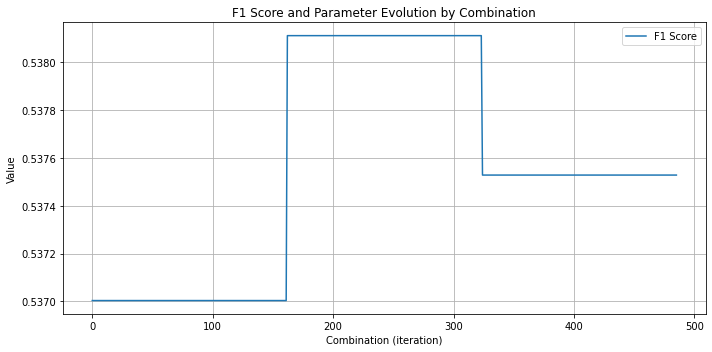

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reset iteration index
results_df = df_resultados.reset_index().rename(columns={'index': 'iteration'})


plt.figure(figsize=(10, 5))

# Plot F1
plt.plot(results_df['iteration'], results_df['f1'], label='F1 Score')

plt.xlabel('Combination (iteration)')
plt.ylabel('Value')
plt.title('F1 Score and Parameter Evolution by Combination')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
prueba =df_resultados[df_resultados['f1']>0.8]

In [ ]:
prueba.shape

(0, 11)

In [ ]:
10 - 20 - 61

-71

In [ ]:
prueba.pca.unique()

array([], dtype=int64)

In [ ]:
prueba.sort_values(by='f1',ascending=False)

,strides,window,pca,n_neighbors,method,contamination,precision,recall,mae,medae,f1


In [ ]:
prueba.n_neighbors.unique()

array([], dtype=int64)

### Algorithm with bests params

In [ ]:
def evaluate_and_detect_ml(model, X_test, score=10):
    """
    Evalúa modelo ML de detección de anomalías 
    usando scores y threshold basado en percentil.
    """

    # Scores del modelo (anomaly scores)
    train_scores = model.decision_scores_               # ya calculados tras fit()
    test_scores = model.decision_function(X_test)       # calcular en test
        
    # y_true (0=normal, 1=anómalo)
    y_true = np.concatenate([
        np.zeros(len(train_scores)), 
        np.ones(len(test_scores))
    ])
    
    # y_pred según threshold
    y_pred = np.concatenate([
        (train_scores > score).astype(int),
        (test_scores > score).astype(int)
    ])
    
    # Métricas
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true,y_pred)
    accuracy  = (tp + tn) / (tp + tn + fp + fn)

    metrics = {
        'score': score,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc': roc
    }
    
    return train_scores, test_scores, metrics

In [ ]:
windows_train, windows_test, metadata_train, metadata_test = create_sliding_windows(
                df, 
                window_size=60, 
                stride=15)

X_train, X_test, scaler, pca, all_features = prepare_data_model_with_pca(windows_train, windows_test, pca_components=10)

knn = KNN(
    n_neighbors=20,
    method='median',
    contamination=0.005,
    n_jobs=-1
)

knn.fit(X_train)

Ventanas train (normales): 4872
Ventanas test (con anomalías): 2838
Registros totales en train: 292320
Registros totales en test: 170280
Registros con anomalía en test: 86508
Eventos únicos en test: 511

Aplicando PCA...
Dimensión original: 3660
Dimensión PCA: 10
Varianza explicada acumulada: 0.8618467258207538


KNN(algorithm='auto', contamination=0.005, leaf_size=30, method='median',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
  radius=1.0)

In [ ]:
results = []
windows_train, windows_test, metadata_train, metadata_test = create_sliding_windows(
                df, 
                window_size=60, 
                stride=15)

X_train, X_test, scaler, pca, all_features = prepare_data_model_with_pca(windows_train, windows_test, pca_components=10)

for v in range(5,100, 5): #EXPERIMENT_CONFIG['n_neighbors']:

    knn = KNN(
        n_neighbors=v,
        method='median',
        contamination=0.01,
        n_jobs=-1
    )
    knn.fit(X_train)
    i,j, metrics = evaluate_and_detect_ml(knn, X_test, score=10)
    metrics['n_neighbors']= v 
    results.append(metrics)


Ventanas train (normales): 4872
Ventanas test (con anomalías): 2838
Registros totales en train: 292320
Registros totales en test: 170280
Registros con anomalía en test: 86508
Eventos únicos en test: 511

Aplicando PCA...
Dimensión original: 3660
Dimensión PCA: 10
Varianza explicada acumulada: 0.861846725820775


In [ ]:
results_neighbors = pd.DataFrame(results)

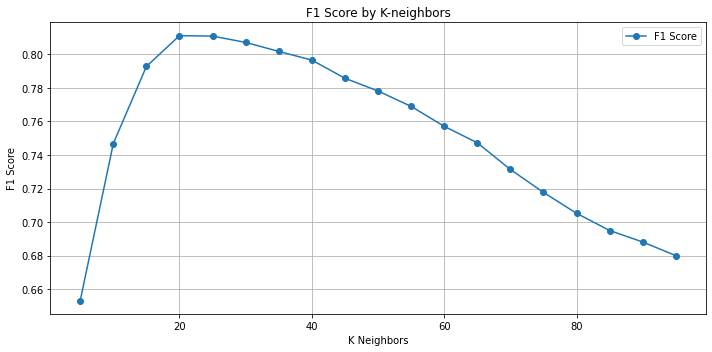

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reset iteration index

plt.figure(figsize=(10, 5))

# Plot F1
plt.plot(results_neighbors['n_neighbors'], results_neighbors['f1'],
         marker='o', label='F1 Score')

#plt.xticks(sorted(results_neighbors['n_neighbors'].unique()))
plt.xlabel('K Neighbors')
plt.ylabel('F1 Score')
plt.title('F1 Score by K-neighbors')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
